In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
from datetime import datetime, timedelta
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

## funciones

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

# Importar y arreglar datos

In [7]:
# feb16 = xr.open_dataset("data/adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")
vert_burst = pd.read_csv('burst_vert.csv')

In [8]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [9]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

vert_burst.index = pd.to_datetime(vert_burst['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
vert_burst = vert_burst.drop(['Unnamed: 0'], axis=1)

In [10]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

# DC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [11]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [44]:
NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

In [12]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [13]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [14]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [15]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [16]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [17]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime(2012,2,14,19,50,0), datetime(2012,2,22,11,50,0), datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [18]:
#Importar datos de backscatter
bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
bks_drp1 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp1.npy")
bks_drp2 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp2.npy")
bks_drp3 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp3.npy")
bks_drp4 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp4.npy")
# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

## Perfiles

In [19]:
p1 = pd.read_csv("data/perfil1.csv", sep=';')
p1 = p1.drop(['Conductividad', 'Presión', 'Turbidez','Conduct Especifica', 'Density anomaly', 'C'], axis=1)

## Densidad

In [20]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [21]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [22]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [23]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

## viento

In [24]:
rho_air = 1.2
cd = 0.0012

dfw = rho_air*cd*dfw*abs(dfw)

# Revision de datos

In [25]:
dc1 = DC_1.loc[datetime(2012,2,11,0,0,0):datetime(2012,2,24,21,5,0)]

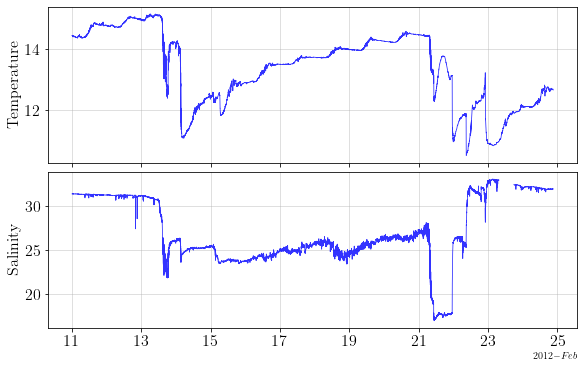

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Temperature ",
          fontsize=16)

ax1.plot(dc1.index, dc1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity ",
          fontsize=16)

ax2.plot(dc1.index, dc1["Salinity"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))



# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [27]:
## Esta funcion considera que el ultimo número es un valor correcto 
## Verificar antes que el ultimo valor esté ok
def del_err(ds):
    for i in range(len(ds)-1, 0, -1):
        if abs(ds[i] - ds[i-1])>1.2:
            ds = ds.drop(ds.index[i])                                   
    return ds  

In [28]:
dc1 = DC_1.loc[datetime(2012,2,11):datetime(2012,3,8)]
dc2 = DC_2.loc[datetime(2012,2,11):datetime(2012,3,8)]

In [29]:
DC_1["Sal_del"] = del_err(DC_1["Salinity"])
DC_2["Sal_del"] = del_err(DC_2["Salinity"])
DC_3["Sal_del"] = del_err(DC_3["Salinity"])
DC_4["Sal_del"] = del_err(DC_4["Salinity"])

In [45]:
NM_2["Sal_del"] = del_err(NM_2["Salinity"])
NM_3["Sal_del"] = del_err(NM_3["Salinity"])
NM_1["Sal_del"] = del_err(NM_1["Salinity"])

In [31]:
ML_2["Sal_del"] = del_err(ML_2["Salinity"])
ML_1["Sal_del"] = del_err(ML_1["Salinity"])

In [32]:
PC_1["Sal_del"] = del_err(PC_1["Salinity"])

In [33]:
t1 = np.arange(datetime(2012,1,17,12,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
DC_1 = DC_1.drop(t1)

In [34]:
DC_2 = DC_2.drop(t1)
DC_3 = DC_3.drop(t1)
DC_4 = DC_4.drop(t1)

In [50]:
t5 = np.arange(datetime(2012,1,17,11,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t6 = np.arange(datetime(2012,1,17,11,10,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t7 = np.arange(datetime(2012,1,17,12,10,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
DC_2 = DC_2.drop(t5)
DC_3 = DC_3.drop(t6)
DC_4 = DC_4.drop(t7)

KeyError: '[datetime.datetime(2012, 1, 17, 11, 30)\n datetime.datetime(2012, 1, 17, 11, 30, 10)\n datetime.datetime(2012, 1, 17, 11, 30, 20)\n datetime.datetime(2012, 1, 17, 11, 30, 30)\n datetime.datetime(2012, 1, 17, 11, 30, 40)\n datetime.datetime(2012, 1, 17, 11, 30, 50)\n datetime.datetime(2012, 1, 17, 11, 31)\n datetime.datetime(2012, 1, 17, 11, 31, 10)\n datetime.datetime(2012, 1, 17, 11, 31, 20)\n datetime.datetime(2012, 1, 17, 11, 31, 30)\n datetime.datetime(2012, 1, 17, 11, 31, 40)\n datetime.datetime(2012, 1, 17, 11, 31, 50)\n datetime.datetime(2012, 1, 17, 11, 32)\n datetime.datetime(2012, 1, 17, 11, 32, 10)\n datetime.datetime(2012, 1, 17, 11, 32, 20)\n datetime.datetime(2012, 1, 17, 11, 32, 30)\n datetime.datetime(2012, 1, 17, 11, 32, 40)\n datetime.datetime(2012, 1, 17, 11, 32, 50)\n datetime.datetime(2012, 1, 17, 11, 33)\n datetime.datetime(2012, 1, 17, 11, 33, 10)\n datetime.datetime(2012, 1, 17, 11, 33, 20)\n datetime.datetime(2012, 1, 17, 11, 33, 30)\n datetime.datetime(2012, 1, 17, 11, 33, 40)\n datetime.datetime(2012, 1, 17, 11, 33, 50)\n datetime.datetime(2012, 1, 17, 11, 34)\n datetime.datetime(2012, 1, 17, 11, 34, 10)\n datetime.datetime(2012, 1, 17, 11, 34, 20)\n datetime.datetime(2012, 1, 17, 11, 34, 30)\n datetime.datetime(2012, 1, 17, 11, 34, 40)\n datetime.datetime(2012, 1, 17, 11, 34, 50)\n datetime.datetime(2012, 1, 17, 11, 35)\n datetime.datetime(2012, 1, 17, 11, 35, 10)\n datetime.datetime(2012, 1, 17, 11, 35, 20)\n datetime.datetime(2012, 1, 17, 11, 35, 30)\n datetime.datetime(2012, 1, 17, 11, 35, 40)\n datetime.datetime(2012, 1, 17, 11, 35, 50)\n datetime.datetime(2012, 1, 17, 11, 36)\n datetime.datetime(2012, 1, 17, 11, 36, 10)\n datetime.datetime(2012, 1, 17, 11, 36, 20)\n datetime.datetime(2012, 1, 17, 11, 36, 30)\n datetime.datetime(2012, 1, 17, 11, 36, 40)\n datetime.datetime(2012, 1, 17, 11, 36, 50)\n datetime.datetime(2012, 1, 17, 11, 37)\n datetime.datetime(2012, 1, 17, 11, 37, 10)\n datetime.datetime(2012, 1, 17, 11, 37, 20)\n datetime.datetime(2012, 1, 17, 11, 37, 30)\n datetime.datetime(2012, 1, 17, 11, 37, 40)\n datetime.datetime(2012, 1, 17, 11, 37, 50)\n datetime.datetime(2012, 1, 17, 11, 38)\n datetime.datetime(2012, 1, 17, 11, 38, 10)\n datetime.datetime(2012, 1, 17, 11, 38, 20)\n datetime.datetime(2012, 1, 17, 11, 38, 30)\n datetime.datetime(2012, 1, 17, 11, 38, 40)\n datetime.datetime(2012, 1, 17, 11, 38, 50)\n datetime.datetime(2012, 1, 17, 11, 39)\n datetime.datetime(2012, 1, 17, 11, 39, 10)\n datetime.datetime(2012, 1, 17, 11, 39, 20)\n datetime.datetime(2012, 1, 17, 11, 39, 30)\n datetime.datetime(2012, 1, 17, 11, 39, 40)\n datetime.datetime(2012, 1, 17, 11, 39, 50)\n datetime.datetime(2012, 1, 17, 11, 40)\n datetime.datetime(2012, 1, 17, 11, 40, 10)\n datetime.datetime(2012, 1, 17, 11, 40, 20)\n datetime.datetime(2012, 1, 17, 11, 40, 30)\n datetime.datetime(2012, 1, 17, 11, 40, 40)\n datetime.datetime(2012, 1, 17, 11, 40, 50)\n datetime.datetime(2012, 1, 17, 11, 41)\n datetime.datetime(2012, 1, 17, 11, 41, 10)\n datetime.datetime(2012, 1, 17, 11, 41, 20)\n datetime.datetime(2012, 1, 17, 11, 41, 30)\n datetime.datetime(2012, 1, 17, 11, 41, 40)\n datetime.datetime(2012, 1, 17, 11, 41, 50)\n datetime.datetime(2012, 1, 17, 11, 42)\n datetime.datetime(2012, 1, 17, 11, 42, 10)\n datetime.datetime(2012, 1, 17, 11, 42, 20)\n datetime.datetime(2012, 1, 17, 11, 42, 30)\n datetime.datetime(2012, 1, 17, 11, 42, 40)\n datetime.datetime(2012, 1, 17, 11, 42, 50)\n datetime.datetime(2012, 1, 17, 11, 43)\n datetime.datetime(2012, 1, 17, 11, 43, 10)\n datetime.datetime(2012, 1, 17, 11, 43, 20)\n datetime.datetime(2012, 1, 17, 11, 43, 30)\n datetime.datetime(2012, 1, 17, 11, 43, 40)\n datetime.datetime(2012, 1, 17, 11, 43, 50)\n datetime.datetime(2012, 1, 17, 11, 44)\n datetime.datetime(2012, 1, 17, 11, 44, 10)\n datetime.datetime(2012, 1, 17, 11, 44, 20)\n datetime.datetime(2012, 1, 17, 11, 44, 30)\n datetime.datetime(2012, 1, 17, 11, 44, 40)\n datetime.datetime(2012, 1, 17, 11, 44, 50)\n datetime.datetime(2012, 1, 17, 11, 45)\n datetime.datetime(2012, 1, 17, 11, 45, 10)\n datetime.datetime(2012, 1, 17, 11, 45, 20)\n datetime.datetime(2012, 1, 17, 11, 45, 30)\n datetime.datetime(2012, 1, 17, 11, 45, 40)\n datetime.datetime(2012, 1, 17, 11, 45, 50)\n datetime.datetime(2012, 1, 17, 11, 46)\n datetime.datetime(2012, 1, 17, 11, 46, 10)\n datetime.datetime(2012, 1, 17, 11, 46, 20)\n datetime.datetime(2012, 1, 17, 11, 46, 30)\n datetime.datetime(2012, 1, 17, 11, 46, 40)\n datetime.datetime(2012, 1, 17, 11, 46, 50)\n datetime.datetime(2012, 1, 17, 11, 47)\n datetime.datetime(2012, 1, 17, 11, 47, 10)\n datetime.datetime(2012, 1, 17, 11, 47, 20)\n datetime.datetime(2012, 1, 17, 11, 47, 30)\n datetime.datetime(2012, 1, 17, 11, 47, 40)\n datetime.datetime(2012, 1, 17, 11, 47, 50)\n datetime.datetime(2012, 1, 17, 11, 48)\n datetime.datetime(2012, 1, 17, 11, 48, 10)\n datetime.datetime(2012, 1, 17, 11, 48, 20)\n datetime.datetime(2012, 1, 17, 11, 48, 30)\n datetime.datetime(2012, 1, 17, 11, 48, 40)\n datetime.datetime(2012, 1, 17, 11, 48, 50)\n datetime.datetime(2012, 1, 17, 11, 49)\n datetime.datetime(2012, 1, 17, 11, 49, 10)\n datetime.datetime(2012, 1, 17, 11, 49, 20)\n datetime.datetime(2012, 1, 17, 11, 49, 30)\n datetime.datetime(2012, 1, 17, 11, 49, 40)\n datetime.datetime(2012, 1, 17, 11, 49, 50)\n datetime.datetime(2012, 1, 17, 11, 50)\n datetime.datetime(2012, 1, 17, 11, 50, 10)\n datetime.datetime(2012, 1, 17, 11, 50, 20)\n datetime.datetime(2012, 1, 17, 11, 50, 30)\n datetime.datetime(2012, 1, 17, 11, 50, 40)\n datetime.datetime(2012, 1, 17, 11, 50, 50)\n datetime.datetime(2012, 1, 17, 11, 51)\n datetime.datetime(2012, 1, 17, 11, 51, 10)\n datetime.datetime(2012, 1, 17, 11, 51, 20)\n datetime.datetime(2012, 1, 17, 11, 51, 30)\n datetime.datetime(2012, 1, 17, 11, 51, 40)\n datetime.datetime(2012, 1, 17, 11, 51, 50)\n datetime.datetime(2012, 1, 17, 11, 52)\n datetime.datetime(2012, 1, 17, 11, 52, 10)\n datetime.datetime(2012, 1, 17, 11, 52, 20)\n datetime.datetime(2012, 1, 17, 11, 52, 30)\n datetime.datetime(2012, 1, 17, 11, 52, 40)\n datetime.datetime(2012, 1, 17, 11, 52, 50)\n datetime.datetime(2012, 1, 17, 11, 53)\n datetime.datetime(2012, 1, 17, 11, 53, 10)\n datetime.datetime(2012, 1, 17, 11, 53, 20)\n datetime.datetime(2012, 1, 17, 11, 53, 30)\n datetime.datetime(2012, 1, 17, 11, 53, 40)\n datetime.datetime(2012, 1, 17, 11, 53, 50)\n datetime.datetime(2012, 1, 17, 11, 54)\n datetime.datetime(2012, 1, 17, 11, 54, 10)\n datetime.datetime(2012, 1, 17, 11, 54, 20)\n datetime.datetime(2012, 1, 17, 11, 54, 30)\n datetime.datetime(2012, 1, 17, 11, 54, 40)\n datetime.datetime(2012, 1, 17, 11, 54, 50)\n datetime.datetime(2012, 1, 17, 11, 55)\n datetime.datetime(2012, 1, 17, 11, 55, 10)\n datetime.datetime(2012, 1, 17, 11, 55, 20)\n datetime.datetime(2012, 1, 17, 11, 55, 30)\n datetime.datetime(2012, 1, 17, 11, 55, 40)\n datetime.datetime(2012, 1, 17, 11, 55, 50)\n datetime.datetime(2012, 1, 17, 11, 56)\n datetime.datetime(2012, 1, 17, 11, 56, 10)\n datetime.datetime(2012, 1, 17, 11, 56, 20)\n datetime.datetime(2012, 1, 17, 11, 56, 30)\n datetime.datetime(2012, 1, 17, 11, 56, 40)\n datetime.datetime(2012, 1, 17, 11, 56, 50)\n datetime.datetime(2012, 1, 17, 11, 57)\n datetime.datetime(2012, 1, 17, 11, 57, 10)\n datetime.datetime(2012, 1, 17, 11, 57, 20)\n datetime.datetime(2012, 1, 17, 11, 57, 30)\n datetime.datetime(2012, 1, 17, 11, 57, 40)\n datetime.datetime(2012, 1, 17, 11, 57, 50)\n datetime.datetime(2012, 1, 17, 11, 58)\n datetime.datetime(2012, 1, 17, 11, 58, 10)\n datetime.datetime(2012, 1, 17, 11, 58, 20)\n datetime.datetime(2012, 1, 17, 11, 58, 30)\n datetime.datetime(2012, 1, 17, 11, 58, 40)\n datetime.datetime(2012, 1, 17, 11, 58, 50)\n datetime.datetime(2012, 1, 17, 11, 59)\n datetime.datetime(2012, 1, 17, 11, 59, 10)\n datetime.datetime(2012, 1, 17, 11, 59, 20)\n datetime.datetime(2012, 1, 17, 11, 59, 30)\n datetime.datetime(2012, 1, 17, 11, 59, 40)\n datetime.datetime(2012, 1, 17, 11, 59, 50)\n datetime.datetime(2012, 1, 17, 12, 0)\n datetime.datetime(2012, 1, 17, 12, 0, 10)\n datetime.datetime(2012, 1, 17, 12, 0, 20)\n datetime.datetime(2012, 1, 17, 12, 0, 30)\n datetime.datetime(2012, 1, 17, 12, 0, 40)\n datetime.datetime(2012, 1, 17, 12, 0, 50)\n datetime.datetime(2012, 1, 17, 12, 1)\n datetime.datetime(2012, 1, 17, 12, 1, 10)\n datetime.datetime(2012, 1, 17, 12, 1, 20)\n datetime.datetime(2012, 1, 17, 12, 1, 30)\n datetime.datetime(2012, 1, 17, 12, 1, 40)\n datetime.datetime(2012, 1, 17, 12, 1, 50)\n datetime.datetime(2012, 1, 17, 12, 2)\n datetime.datetime(2012, 1, 17, 12, 2, 10)\n datetime.datetime(2012, 1, 17, 12, 2, 20)\n datetime.datetime(2012, 1, 17, 12, 2, 30)\n datetime.datetime(2012, 1, 17, 12, 2, 40)\n datetime.datetime(2012, 1, 17, 12, 2, 50)\n datetime.datetime(2012, 1, 17, 12, 3)\n datetime.datetime(2012, 1, 17, 12, 3, 10)\n datetime.datetime(2012, 1, 17, 12, 3, 20)\n datetime.datetime(2012, 1, 17, 12, 3, 30)\n datetime.datetime(2012, 1, 17, 12, 3, 40)\n datetime.datetime(2012, 1, 17, 12, 3, 50)\n datetime.datetime(2012, 1, 17, 12, 4)\n datetime.datetime(2012, 1, 17, 12, 4, 10)\n datetime.datetime(2012, 1, 17, 12, 4, 20)\n datetime.datetime(2012, 1, 17, 12, 4, 30)\n datetime.datetime(2012, 1, 17, 12, 4, 40)\n datetime.datetime(2012, 1, 17, 12, 4, 50)\n datetime.datetime(2012, 1, 17, 12, 5)\n datetime.datetime(2012, 1, 17, 12, 5, 10)\n datetime.datetime(2012, 1, 17, 12, 5, 20)\n datetime.datetime(2012, 1, 17, 12, 5, 30)\n datetime.datetime(2012, 1, 17, 12, 5, 40)\n datetime.datetime(2012, 1, 17, 12, 5, 50)\n datetime.datetime(2012, 1, 17, 12, 6)\n datetime.datetime(2012, 1, 17, 12, 6, 10)\n datetime.datetime(2012, 1, 17, 12, 6, 20)\n datetime.datetime(2012, 1, 17, 12, 6, 30)\n datetime.datetime(2012, 1, 17, 12, 6, 40)\n datetime.datetime(2012, 1, 17, 12, 6, 50)\n datetime.datetime(2012, 1, 17, 12, 7)\n datetime.datetime(2012, 1, 17, 12, 7, 10)\n datetime.datetime(2012, 1, 17, 12, 7, 20)\n datetime.datetime(2012, 1, 17, 12, 7, 30)\n datetime.datetime(2012, 1, 17, 12, 7, 40)\n datetime.datetime(2012, 1, 17, 12, 7, 50)\n datetime.datetime(2012, 1, 17, 12, 8)\n datetime.datetime(2012, 1, 17, 12, 8, 10)\n datetime.datetime(2012, 1, 17, 12, 8, 20)\n datetime.datetime(2012, 1, 17, 12, 8, 30)\n datetime.datetime(2012, 1, 17, 12, 8, 40)\n datetime.datetime(2012, 1, 17, 12, 8, 50)\n datetime.datetime(2012, 1, 17, 12, 9)\n datetime.datetime(2012, 1, 17, 12, 9, 10)\n datetime.datetime(2012, 1, 17, 12, 9, 20)\n datetime.datetime(2012, 1, 17, 12, 9, 30)\n datetime.datetime(2012, 1, 17, 12, 9, 40)\n datetime.datetime(2012, 1, 17, 12, 9, 50)\n datetime.datetime(2012, 1, 17, 12, 10)\n datetime.datetime(2012, 1, 17, 12, 10, 10)\n datetime.datetime(2012, 1, 17, 12, 10, 20)\n datetime.datetime(2012, 1, 17, 12, 10, 30)\n datetime.datetime(2012, 1, 17, 12, 10, 40)\n datetime.datetime(2012, 1, 17, 12, 10, 50)\n datetime.datetime(2012, 1, 17, 12, 11)\n datetime.datetime(2012, 1, 17, 12, 11, 10)\n datetime.datetime(2012, 1, 17, 12, 11, 20)\n datetime.datetime(2012, 1, 17, 12, 11, 30)\n datetime.datetime(2012, 1, 17, 12, 11, 40)\n datetime.datetime(2012, 1, 17, 12, 11, 50)\n datetime.datetime(2012, 1, 17, 12, 12)\n datetime.datetime(2012, 1, 17, 12, 12, 10)\n datetime.datetime(2012, 1, 17, 12, 12, 20)\n datetime.datetime(2012, 1, 17, 12, 12, 30)\n datetime.datetime(2012, 1, 17, 12, 12, 40)\n datetime.datetime(2012, 1, 17, 12, 12, 50)\n datetime.datetime(2012, 1, 17, 12, 13)\n datetime.datetime(2012, 1, 17, 12, 13, 10)\n datetime.datetime(2012, 1, 17, 12, 13, 20)\n datetime.datetime(2012, 1, 17, 12, 13, 30)\n datetime.datetime(2012, 1, 17, 12, 13, 40)\n datetime.datetime(2012, 1, 17, 12, 13, 50)\n datetime.datetime(2012, 1, 17, 12, 14)\n datetime.datetime(2012, 1, 17, 12, 14, 10)\n datetime.datetime(2012, 1, 17, 12, 14, 20)\n datetime.datetime(2012, 1, 17, 12, 14, 30)\n datetime.datetime(2012, 1, 17, 12, 14, 40)\n datetime.datetime(2012, 1, 17, 12, 14, 50)\n datetime.datetime(2012, 1, 17, 12, 15)\n datetime.datetime(2012, 1, 17, 12, 15, 10)\n datetime.datetime(2012, 1, 17, 12, 15, 20)\n datetime.datetime(2012, 1, 17, 12, 15, 30)\n datetime.datetime(2012, 1, 17, 12, 15, 40)\n datetime.datetime(2012, 1, 17, 12, 15, 50)\n datetime.datetime(2012, 1, 17, 12, 16)\n datetime.datetime(2012, 1, 17, 12, 16, 10)\n datetime.datetime(2012, 1, 17, 12, 16, 20)\n datetime.datetime(2012, 1, 17, 12, 16, 30)\n datetime.datetime(2012, 1, 17, 12, 16, 40)\n datetime.datetime(2012, 1, 17, 12, 16, 50)\n datetime.datetime(2012, 1, 17, 12, 17)\n datetime.datetime(2012, 1, 17, 12, 17, 10)\n datetime.datetime(2012, 1, 17, 12, 17, 20)\n datetime.datetime(2012, 1, 17, 12, 17, 30)\n datetime.datetime(2012, 1, 17, 12, 17, 40)\n datetime.datetime(2012, 1, 17, 12, 17, 50)\n datetime.datetime(2012, 1, 17, 12, 18)\n datetime.datetime(2012, 1, 17, 12, 18, 10)\n datetime.datetime(2012, 1, 17, 12, 18, 20)\n datetime.datetime(2012, 1, 17, 12, 18, 30)\n datetime.datetime(2012, 1, 17, 12, 18, 40)\n datetime.datetime(2012, 1, 17, 12, 18, 50)\n datetime.datetime(2012, 1, 17, 12, 19)\n datetime.datetime(2012, 1, 17, 12, 19, 10)\n datetime.datetime(2012, 1, 17, 12, 19, 20)\n datetime.datetime(2012, 1, 17, 12, 19, 30)\n datetime.datetime(2012, 1, 17, 12, 19, 40)\n datetime.datetime(2012, 1, 17, 12, 19, 50)\n datetime.datetime(2012, 1, 17, 12, 20)\n datetime.datetime(2012, 1, 17, 12, 20, 10)\n datetime.datetime(2012, 1, 17, 12, 20, 20)\n datetime.datetime(2012, 1, 17, 12, 20, 30)\n datetime.datetime(2012, 1, 17, 12, 20, 40)\n datetime.datetime(2012, 1, 17, 12, 20, 50)\n datetime.datetime(2012, 1, 17, 12, 21)\n datetime.datetime(2012, 1, 17, 12, 21, 10)\n datetime.datetime(2012, 1, 17, 12, 21, 20)\n datetime.datetime(2012, 1, 17, 12, 21, 30)\n datetime.datetime(2012, 1, 17, 12, 21, 40)\n datetime.datetime(2012, 1, 17, 12, 21, 50)\n datetime.datetime(2012, 1, 17, 12, 22)\n datetime.datetime(2012, 1, 17, 12, 22, 10)\n datetime.datetime(2012, 1, 17, 12, 22, 20)\n datetime.datetime(2012, 1, 17, 12, 22, 30)\n datetime.datetime(2012, 1, 17, 12, 22, 40)\n datetime.datetime(2012, 1, 17, 12, 22, 50)\n datetime.datetime(2012, 1, 17, 12, 23)\n datetime.datetime(2012, 1, 17, 12, 23, 10)\n datetime.datetime(2012, 1, 17, 12, 23, 20)\n datetime.datetime(2012, 1, 17, 12, 23, 30)\n datetime.datetime(2012, 1, 17, 12, 23, 40)\n datetime.datetime(2012, 1, 17, 12, 23, 50)\n datetime.datetime(2012, 1, 17, 12, 24)\n datetime.datetime(2012, 1, 17, 12, 24, 10)\n datetime.datetime(2012, 1, 17, 12, 24, 20)\n datetime.datetime(2012, 1, 17, 12, 24, 30)\n datetime.datetime(2012, 1, 17, 12, 24, 40)\n datetime.datetime(2012, 1, 17, 12, 24, 50)\n datetime.datetime(2012, 1, 17, 12, 25)\n datetime.datetime(2012, 1, 17, 12, 25, 10)\n datetime.datetime(2012, 1, 17, 12, 25, 20)\n datetime.datetime(2012, 1, 17, 12, 25, 30)\n datetime.datetime(2012, 1, 17, 12, 25, 40)\n datetime.datetime(2012, 1, 17, 12, 25, 50)\n datetime.datetime(2012, 1, 17, 12, 26)\n datetime.datetime(2012, 1, 17, 12, 26, 10)\n datetime.datetime(2012, 1, 17, 12, 26, 20)\n datetime.datetime(2012, 1, 17, 12, 26, 30)\n datetime.datetime(2012, 1, 17, 12, 26, 40)\n datetime.datetime(2012, 1, 17, 12, 26, 50)\n datetime.datetime(2012, 1, 17, 12, 27)\n datetime.datetime(2012, 1, 17, 12, 27, 10)\n datetime.datetime(2012, 1, 17, 12, 27, 20)\n datetime.datetime(2012, 1, 17, 12, 27, 30)\n datetime.datetime(2012, 1, 17, 12, 27, 40)\n datetime.datetime(2012, 1, 17, 12, 27, 50)\n datetime.datetime(2012, 1, 17, 12, 28)\n datetime.datetime(2012, 1, 17, 12, 28, 10)\n datetime.datetime(2012, 1, 17, 12, 28, 20)\n datetime.datetime(2012, 1, 17, 12, 28, 30)\n datetime.datetime(2012, 1, 17, 12, 28, 40)\n datetime.datetime(2012, 1, 17, 12, 28, 50)\n datetime.datetime(2012, 1, 17, 12, 29)\n datetime.datetime(2012, 1, 17, 12, 29, 10)\n datetime.datetime(2012, 1, 17, 12, 29, 20)\n datetime.datetime(2012, 1, 17, 12, 29, 30)\n datetime.datetime(2012, 1, 17, 12, 29, 40)\n datetime.datetime(2012, 1, 17, 12, 29, 50)] not found in axis'

In [54]:
NM_2

,Depth,Salinity,Temperature,Sal_del
Datetime,,,,
2012-01-17 14:00:00,0.933440,7.359749,8.371089,7.359749
2012-01-17 14:00:30,0.932659,7.296814,8.498212,7.296814
2012-01-17 14:01:00,0.934829,7.288763,8.521070,7.288763
2012-01-17 14:01:30,0.933527,7.303573,8.516115,7.303573
2012-01-17 14:02:00,0.934420,7.322527,8.412753,7.322527
...,...,...,...,...
2012-03-22 11:48:00,0.143950,0.000000,18.049716,0.000000
2012-03-22 11:48:30,0.144223,0.013213,18.154211,0.013213
2012-03-22 11:49:00,0.144062,0.009959,18.310734,0.009959


In [53]:
t2 = np.arange(datetime(2012,1,17,10,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)
t3 = np.arange(datetime(2012,1,17,6,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)
t4 = np.arange(datetime(2012,1,17,6,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
NM_2 = NM_2.drop(t2)
NM_3 = NM_3.drop(t3)
NM_1 = NM_1.drop(t4)

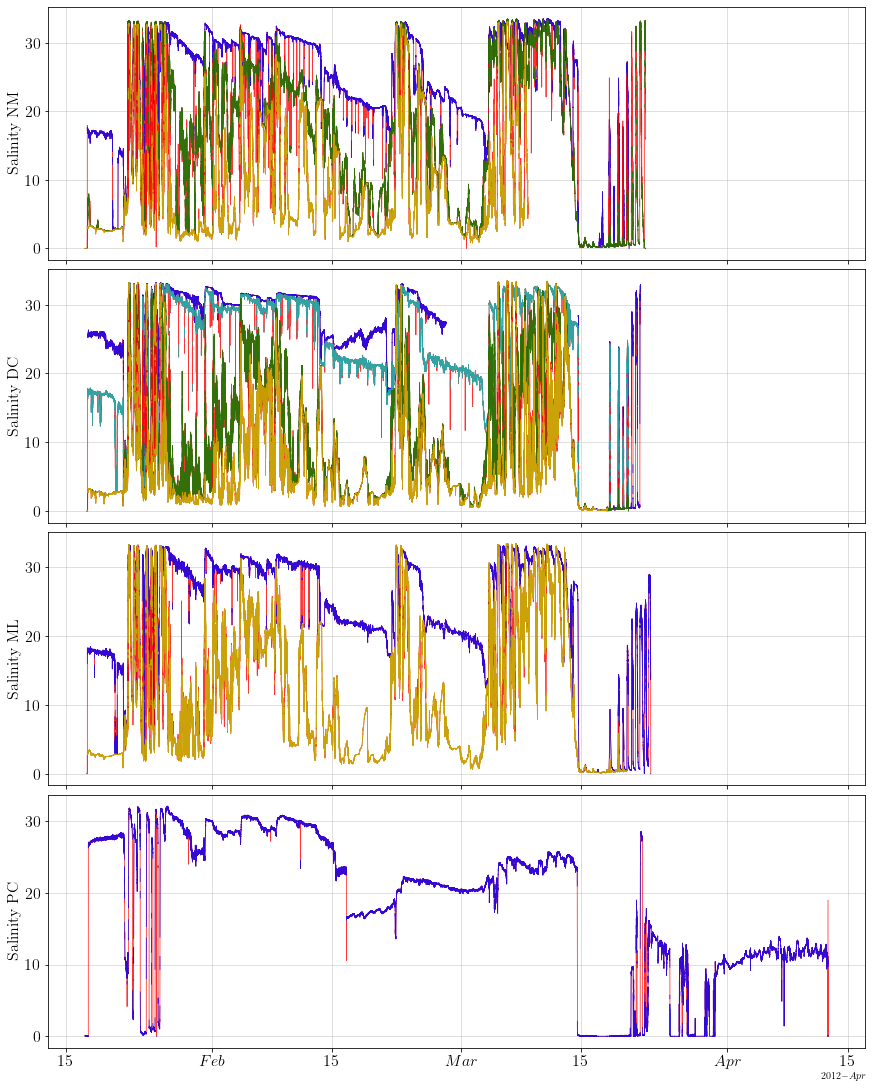

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

ax1.plot(NM_1.index, NM_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_1.index, NM_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_2.index, NM_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_2.index, NM_2["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_3.index, NM_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_3.index, NM_3["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

ax2.plot(DC_1.index, DC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_1.index, DC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_2.index, DC_2["Sal_del"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_3.index, DC_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_3.index, DC_3["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_4.index, DC_4["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_4.index, DC_4["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

ax3.plot(ML_1.index, ML_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(ML_1.index, ML_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax3.plot(ML_2.index, ML_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(ML_2.index, ML_2["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

ax4.plot(PC_1.index, PC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax4.plot(PC_1.index, PC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

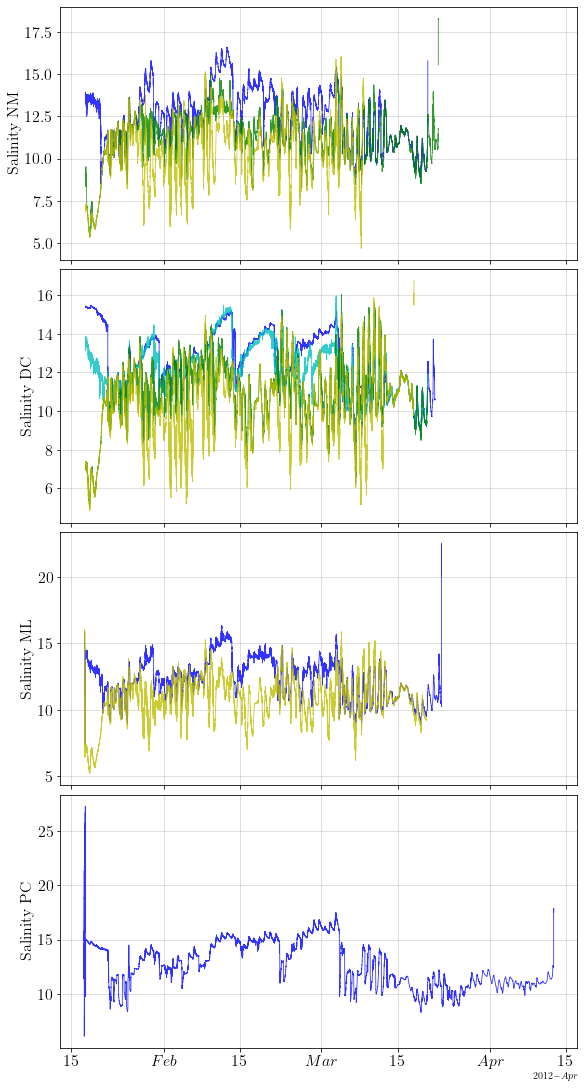

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(8, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

ax1.plot(NM_1.index, NM_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_1.index, NM_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_2.index, NM_2["Temperature"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_2.index, NM_2["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_3.index, NM_3["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_3.index, NM_3["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

ax2.plot(DC_1.index, DC_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_1.index, DC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_2.index, DC_2["Temperature"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_2.index, DC_2["Sal_del"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_3.index, DC_3["Temperature"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_3.index, DC_3["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_4.index, DC_4["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_4.index, DC_4["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

ax3.plot(ML_1.index, ML_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax3.plot(ML_1.index, ML_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax3.plot(ML_2.index, ML_2["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax3.plot(ML_2.index, ML_2["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

ax4.plot(PC_1.index, PC_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax4.plot(PC_1.index, PC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

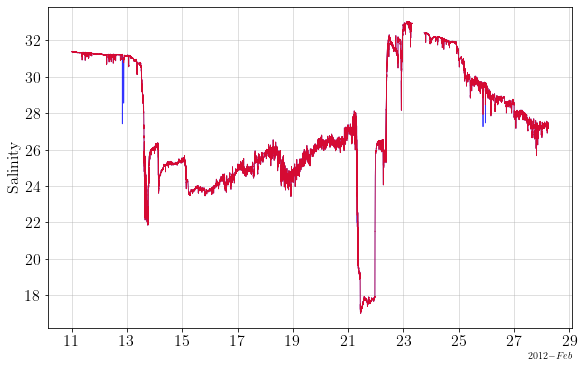

In [ ]:
fig, ( ax2) = plt.subplots(nrows=1, figsize=(8, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

# ax1.set_ylabel(r"Temperature ",
#           fontsize=16)

# ax1.plot(dc1.index, dc1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity ",
          fontsize=16)

ax2.plot(dc1.index, dc1["Salinity"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(test.index, test.values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))



# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [56]:
NM_1.index.name = "time"
NM_1.columns.name = "variables"
nm1a = xr.DataArray(NM_1)
nm1a

<xarray.DataArray (time: 544186, variables: 4)>
array([[ 1.83858054, 17.23732859, 13.7972217 , 17.23732859],
       [ 1.83851701, 17.21812225, 13.79365692, 17.21812225],
       [ 1.83884099, 17.20655284, 13.78574059, 17.20655284],
       ...,
       [ 0.10184033,  0.        , 15.75522166,  0.        ],
       [ 0.10169066,  0.        , 15.78460155,  0.        ],
       [ 0.10168708,  0.        , 15.79669021,  0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 2012-01-17T14:00:00 ... 2012-03-20T13:37:30
  * variables  (variables) object 'Depth' 'Salinity' 'Temperature' 'Sal_del'